In [4]:
import pandas as pd

df = pd.DataFrame({"Name": ["Bhumesh", "Alex"], "Score": [95, 87]})
print(df)


      Name  Score
0  Bhumesh     95
1     Alex     87


In [5]:
# Cell 1 — imports and small config
import pandas as pd                # pandas: primary library for tabular data (DataFrame)
import matplotlib.pyplot as plt    # plotting library; pandas plotting uses matplotlib under the hood


In [6]:
import os 
print(os.getcwd()) # to know from where it reads files

C:\Users\acer


In [7]:
events = pd.read_csv(r"D:\Workplace\Anaconda\Lib\site-packages\pandas\io\parsers\upi_txn_events.csv", parse_dates=["event_time"], low_memory=False)
txns  = pd.read_csv(r"D:\Workplace\Anaconda\Lib\site-packages\pandas\io\parsers\upi_transactions.csv", parse_dates=["initiated_at"], low_memory=False)


In [8]:
print("events rows:", len(events))
print("txns rows:  ", len(txns))
events.head() # shows first 5 rows of events DataFrame

events rows: 37021
txns rows:   8000


,txn_id,stage,event_time,success,error_code
0,TX100000,init,2025-07-24 05:37:05.001158,NaN,NaN
1,TX100000,amount_entered,2025-07-24 05:37:18.001158,NaN,NaN
2,TX100000,pin_entered,2025-07-24 05:37:29.001158,NaN,NaN
3,TX100000,bank_auth,2025-07-24 05:37:46.001158,NaN,NaN
4,TX100000,completed,2025-07-24 05:37:49.001158,False,BANK_DOWN


In [9]:
# merge events + txns into one DataFrame
df = events.merge(txns, on="txn_id", how="left", suffixes=("_event","_txn"))
df.head()

,txn_id,stage,event_time,success,error_code,user_id,initiated_at,txn_value_inr,bank_name,device_type,network_type,app_version,txn_success,final_error_code
0,TX100000,init,2025-07-24 05:37:05.001158,NaN,NaN,861,2025-07-24 05:37:05.001158,50.0,ICICI,iOS,5G,7.4.1,False,BANK_DOWN
1,TX100000,amount_entered,2025-07-24 05:37:18.001158,NaN,NaN,861,2025-07-24 05:37:05.001158,50.0,ICICI,iOS,5G,7.4.1,False,BANK_DOWN
2,TX100000,pin_entered,2025-07-24 05:37:29.001158,NaN,NaN,861,2025-07-24 05:37:05.001158,50.0,ICICI,iOS,5G,7.4.1,False,BANK_DOWN
3,TX100000,bank_auth,2025-07-24 05:37:46.001158,NaN,NaN,861,2025-07-24 05:37:05.001158,50.0,ICICI,iOS,5G,7.4.1,False,BANK_DOWN
4,TX100000,completed,2025-07-24 05:37:49.001158,False,BANK_DOWN,861,2025-07-24 05:37:05.001158,50.0,ICICI,iOS,5G,7.4.1,False,BANK_DOWN


In [10]:
# pivot so each txn has columns for each stage's earliest timestamp
time_df = df.pivot_table(
    index="txn_id",
    columns="stage",
    values="event_time",
    aggfunc="min"         # take earliest timestamp per txn-stage (if duplicates exist)
).reset_index()


In [11]:
# compute duration (completed - init) and convert to seconds
time_df["duration_sec"] = (time_df["completed"] - time_df["init"]).dt.total_seconds()
print(time_df["duration_sec"])

0       44.0
1        NaN
2        NaN
3       49.0
4       45.0
        ... 
7995     NaN
7996    51.0
7997    26.0
7998    37.0
7999    37.0
Name: duration_sec, Length: 8000, dtype: float64


In [12]:
# attach bank/device info for segmentation
time_df = time_df.merge(txns[["txn_id", "bank_name", "device_type"]], on="txn_id" , how="left")
time_df.head()

,txn_id,abandoned_after_amount,abandoned_after_init,amount_entered,bank_auth,completed,fail_before_bank,init,pin_entered,duration_sec,bank_name,device_type
0,TX100000,NaT,NaT,2025-07-24 05:37:18.001158,2025-07-24 05:37:46.001158,2025-07-24 05:37:49.001158,NaT,2025-07-24 05:37:05.001158,2025-07-24 05:37:29.001158,44.0,ICICI,iOS
1,TX100001,NaT,NaT,2025-07-06 10:54:33.001158,NaT,NaT,2025-07-06 10:55:00.001158,2025-07-06 10:54:16.001158,2025-07-06 10:54:52.001158,NaN,Axis,Android
2,TX100002,2025-08-17 06:48:17.001158,NaT,2025-08-17 06:47:59.001158,NaT,NaT,NaT,2025-08-17 06:47:50.001158,NaT,NaN,PNB,Android
3,TX100003,NaT,NaT,2025-07-24 15:46:37.001158,2025-07-24 15:47:03.001158,2025-07-24 15:47:10.001158,NaT,2025-07-24 15:46:21.001158,2025-07-24 15:46:44.001158,49.0,ICICI,Android
4,TX100004,NaT,NaT,2025-08-12 18:40:15.001158,2025-08-12 18:40:49.001158,2025-08-12 18:40:54.001158,NaT,2025-08-12 18:40:09.001158,2025-08-12 18:40:27.001158,45.0,Axis,Android


In [16]:
# aggregate : average duration by bank and by device
print ("Avg duration by bank (seconds):")
print(time_df.groupby("bank_name")["duration_sec"].median().sort_values())

print("\n Avg duration by device (seconds):")
print(time_df.groupby("device_type")["duration_sec"].median().sort_values())

Avg duration by bank (seconds):
bank_name
Axis     45.0
HDFC     45.0
ICICI    45.0
PNB      45.0
SBI      46.0
Name: duration_sec, dtype: float64

 Avg duration by device (seconds):
device_type
Android    45.0
iOS        45.0
Name: duration_sec, dtype: float64


In [18]:
# error breakdown [Failed transactions]
failed = txns[txns["txn_success"]==False] #boolean filter for transactions table
error_by_bank=failed.groupby(["bank_name", "final_error_code"]).size().reset_index(name="count")
error_by_bank.sort_values("count", ascending=False).head(10)

,bank_name,final_error_code,count
24,SBI,USER_ABORT,369
22,SBI,NETWORK_TIMEOUT,338
14,ICICI,USER_ABORT,258
9,HDFC,USER_ABORT,249
4,Axis,USER_ABORT,225
7,HDFC,NETWORK_TIMEOUT,197
12,ICICI,NETWORK_TIMEOUT,190
2,Axis,NETWORK_TIMEOUT,185
19,PNB,USER_ABORT,169
21,SBI,INCORRECT_PIN,148


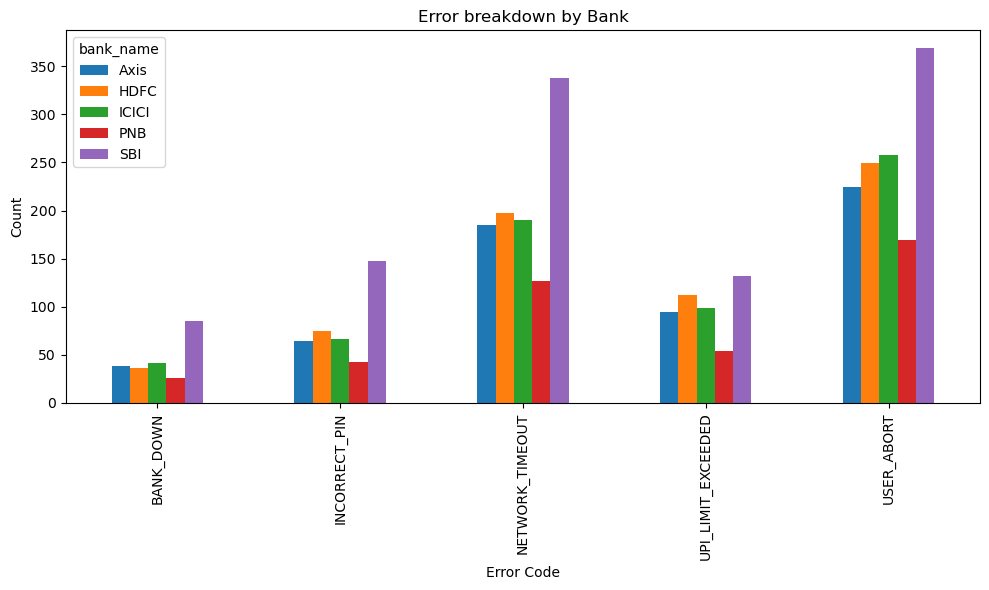

In [19]:
# simple plot of error counts (pivot then plot)
err_pivot=error_by_bank.pivot(index="final_error_code", columns="bank_name", values="count").fillna(0)
err_pivot.plot(kind="bar", figsize=(10,6))
plt.title("Error breakdown by Bank")
plt.ylabel("Count")
plt.xlabel("Error Code")
plt.tight_layout()
plt.show()

In [20]:
# save summary outputs for tableau or github
time_df.to_csv("time_summary.csv", index=False)
error_by_bank.to_csv("error_by_bank.csv", index=False)